# Project: Sentiment Analysis of Bank Customer Reviews using CNN, LSTM, Combined CNN and LSTM, BERT-based approach

## Dataset
The dataset utilized in this research comprises over 10,000 customer reviews sourced from 48 distinct banking institu- tions within the United States. This publicly available dataset can be accessed through the Kaggle community platform, offering a comprehensive collection of customer sentiments towards various banks. The dataset's primary objective is to serve as a resource for training and evaluating the sentiment analysis system proposed in this research. For easy accessibility, the dataset can be downloaded using the following link: https://www.kaggle.com/datasets/trainingdatapro/20000-customers-reviews-on-banks/data. The richness of this dataset not only allows for a detailed exploration of customer feedback but also ensures a diverse and representative sample, crucial for the effectiveness and generalizability of the sentiment analysis model.


In [ ]:
# Import the necessary libraries for performing data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import nltk
    nltk.download('punkt', download_dir='E:/Code/BKU/HK3/NLP')
    nltk.download('stopwords', download_dir='E:/Code/BKU/HK3/NLP')
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
except Exception as e:
    print(f"Error: {e}")

import os
os.environ['NLTK_DATA'] = 'E:/Code/BKU/HK3/NLP'

import re

!pip install transformers

import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
from prettytable import PrettyTable

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

[nltk_data] Downloading package punkt to E:/Code/BKU/HK3/NLP...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to E:/Code/BKU/HK3/NLP...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Importing the dataset
Import the dataset of customer reviews from 48 distinct banks across the United States.

In [ ]:
data = pd.read_csv('E:/Code/BKU/HK3/NLP/Banks.csv')
data

,author,date,location,bank,star,text,like
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,NaN
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,NaN
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0
...,...,...,...,...,...,...,...
3494,Diamond,18.04.2022,"Upland, CA",flagstar,1,"I own a property with my sister, and since she...",3.0
3495,Tarrell,5.04.2022,"Mcdonough, GA",flagstar,1,Really don't know where to start but I really ...,6.0
3496,Jason,4.04.2022,"Gold Canyon, AZ",flagstar,1,I have now spent more time trying just to spea...,6.0
3497,Lisa,1.04.2022,"Watsonville, CA",flagstar,1,"I started a refi in November 2021, it's now Ap...",9.0


## 2. Data Preprocessing

- Add a sentiment column indicating positive and negative reviews based on a specified criteria (e.g., 4-5 stars as positive, 1-3 stars as negative).
- Remove punctuations and numbers from the text.
- Convert the text into lowercase for uniformity.

In [ ]:
data.isnull().sum()

author        1
date          0
location      0
bank          0
star          0
text         13
like        418
dtype: int64

In [ ]:
data = data.dropna(subset=['text'])

In [ ]:
data.isnull().sum()

author        1
date          0
location      0
bank          0
star          0
text          0
like        417
dtype: int64

In [ ]:
reviews_data = data[['star', 'text']]
reviews_data['sentiment'] = reviews_data['star'].apply(lambda x: 0 if x <= 3 else 1)
reviews_data

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3924\1259298755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['sentiment'] = reviews_data['star'].apply(lambda x: 0 if x <= 3 else 1)


,star,text,sentiment
0,5,Very easy to use to view statements and make o...,1
1,5,Merrick Bank has always been good to me for bu...,1
2,4,Times are tough for everyone and I have worked...,1
3,5,I can not asked for a better Credit Card Compa...,1
4,5,Updated on 02/10/2023: I was happy to sign for...,1
...,...,...,...
3494,1,"I own a property with my sister, and since she...",0
3495,1,Really don't know where to start but I really ...,0
3496,1,I have now spent more time trying just to spea...,0
3497,1,"I started a refi in November 2021, it's now Ap...",0


**Clean the text**

In [ ]:
def clean_text(text):

    text = str(text).lower()

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d', '', text)

    stop_words = set(stopwords.words('english'))

    words = tokenization(text)
    cleaned_text = ''
    for word in words:

        if word not in stop_words:
            cleaned_text += ' ' + word

    return cleaned_text


def tokenization(text):

    words = nltk.word_tokenize(text)

    return words

reviews_data

,star,text,sentiment
0,5,Very easy to use to view statements and make o...,1
1,5,Merrick Bank has always been good to me for bu...,1
2,4,Times are tough for everyone and I have worked...,1
3,5,I can not asked for a better Credit Card Compa...,1
4,5,Updated on 02/10/2023: I was happy to sign for...,1
...,...,...,...
3494,1,"I own a property with my sister, and since she...",0
3495,1,Really don't know where to start but I really ...,0
3496,1,I have now spent more time trying just to spea...,0
3497,1,"I started a refi in November 2021, it's now Ap...",0


**Data statistics**

In [ ]:
def get_num_tokens(tokens_list):

    return len(tokens_list)

dataset_info = {
    'Sentiment': ['Positive reviews',
                  'Negative reviews'],
    '#Reviews': [len(reviews_data[reviews_data['sentiment'] == 1]['text']),
                 len(reviews_data[reviews_data['sentiment'] == 0]['text'])],
    'Min. #tokens': [min(reviews_data[reviews_data['sentiment'] == 1]['text'].apply(get_num_tokens)),
                     min(reviews_data[reviews_data['sentiment'] == 0]['text'].apply(get_num_tokens))],
    'Avg. #tokens': [round(reviews_data[reviews_data['sentiment'] == 1]['text'].apply(get_num_tokens).mean()),
                     round(reviews_data[reviews_data['sentiment'] == 0]['text'].apply(get_num_tokens).mean())],
    'Max. #tokens': [max(reviews_data[reviews_data['sentiment'] == 1]['text'].apply(get_num_tokens)),
                     max(reviews_data[reviews_data['sentiment'] == 0]['text'].apply(get_num_tokens))]
}

dataset_info_table = pd.DataFrame(dataset_info)

dataset_info_table

,Sentiment,#Reviews,Min. #tokens,Avg. #tokens,Max. #tokens
0,Positive reviews,844,98,311,951
1,Negative reviews,2642,15,565,1854


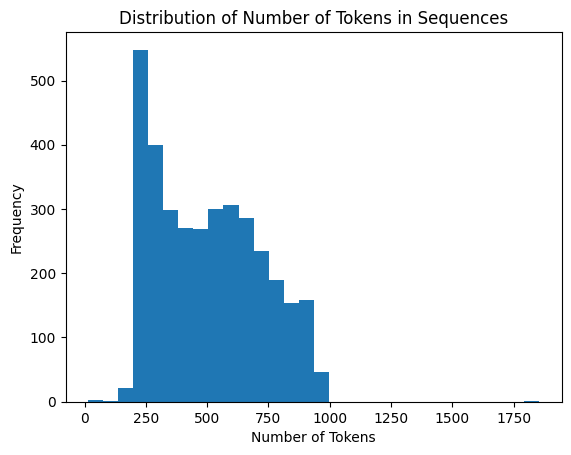

In [ ]:
sequence_lengths = [reviews_data['text'].apply(get_num_tokens)]
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tokens in Sequences')
plt.show()

## 3. CNN Model Training
Systematically divided into three sets: training (80%), and test (20%). Training set instructs the CNN, enabling it to learn patterns and relationships within the data. 

In [ ]:
reviews = pd.DataFrame(reviews_data['text'])
labels = pd.DataFrame(reviews_data['sentiment'])

reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(reviews, labels, test_size=0.2, random_state=100)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(reviews_temp, labels_temp, test_size=0.5, random_state=100)

In [12]:
reviews

,text
0,Very easy to use to view statements and make o...
1,Merrick Bank has always been good to me for bu...
2,Times are tough for everyone and I have worked...
3,I can not asked for a better Credit Card Compa...
4,Updated on 02/10/2023: I was happy to sign for...
...,...
3494,"I own a property with my sister, and since she..."
3495,Really don't know where to start but I really ...
3496,I have now spent more time trying just to spea...
3497,"I started a refi in November 2021, it's now Ap..."


In [13]:
labels

,sentiment
0,1
1,1
2,1
3,1
4,1
...,...
3494,0
3495,0
3496,0
3497,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Dropout
import tensorflow as tf

In [15]:
# Text Preprocessing
MAX_NB_WORDS = 10000  # Maximum number of words to use (vocabulary size)
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences
EMBEDDING_DIM = 100  # Embedding dimension

# Tokenize the text data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(reviews_train['text'])

# Convert text data to sequences of integers
X_train = tokenizer.texts_to_sequences(reviews_train['text'])
X_val = tokenizer.texts_to_sequences(reviews_val['text'])
X_test = tokenizer.texts_to_sequences(reviews_test['text'])

# Pad sequences to ensure the same length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(labels_train)
y_val = to_categorical(labels_val)
y_test = to_categorical(labels_test)

# Build the CNN model
modelCNN = Sequential()

# Embedding layer to convert words into word vectors
modelCNN.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# Convolutional layer to learn features from sequences
modelCNN.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Max pooling layer
modelCNN.add(MaxPooling1D(pool_size=4))

# Dropout layer to prevent overfitting
modelCNN.add(Dropout(0.5))

# Flatten the output to connect to the dense layers
modelCNN.add(Flatten())

# Fully connected dense layer
modelCNN.add(Dense(128, activation='relu'))

# Output layer with softmax for multi-class classification
modelCNN.add(Dense(2, activation='softmax'))  # Adjust '2' for the number of classes (binary classification in this case)

# Compile the model
modelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = modelCNN.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model on the test data
score, accuracy = modelCNN.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions on the test set
predictions = modelCNN.predict(X_test)

# Optionally, convert predictions to class labels (0 or 1)
predicted_labels = predictions.argmax(axis=1)

# Display some predictions (optional)
for i in range(5):
    print(f"Review: {reviews_test.iloc[i]['text']}")
    print(f"True Sentiment: {labels_test.iloc[i]['sentiment']}")
    print(f"Predicted Sentiment: {predicted_labels[i]}")
    print("-" * 50)


Epoch 1/5


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7512 - loss: 0.4608 - val_accuracy: 0.8510 - val_loss: 0.3499
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8930 - loss: 0.2755 - val_accuracy: 0.8997 - val_loss: 0.2327
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9701 - loss: 0.0882 - val_accuracy: 0.9226 - val_loss: 0.2559
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.0349 - val_accuracy: 0.8997 - val_loss: 0.2931
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9284 - val_loss: 0.3419
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9612 - loss: 0.1562 
Test Accuracy: 95.70%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Review: I would recommend Merrick to anyone. While rebuilding my credit I have found that their website was very easy to use and very professional. Any interaction with their staff was always cordial and professional.
True Sentiment: 1
Predicted Se

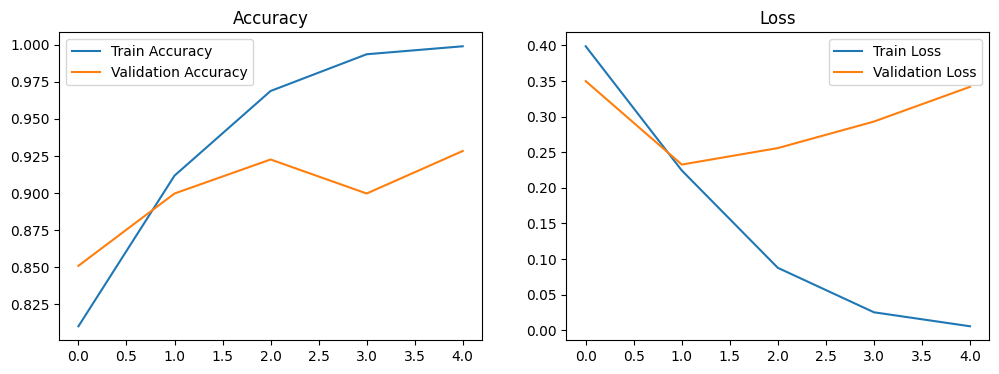

In [16]:
# 5. (Tùy chọn) Vẽ đồ thị accuracy và loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## 4. LSTM Model Training
Systematically divided into three sets: training (80%), and test (20%). Training set instructs the LSTM, enabling it to learn patterns and relationships within the data. 

In [17]:
# Define input variable and target variable
reviews = pd.DataFrame(reviews_data['text'])
labels = pd.DataFrame(reviews_data['sentiment'])

# Split the dataset into 3 parts, including training set (80%), validation set (10%), and test set (10%)
reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(reviews, labels, test_size=0.2, random_state=100)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(reviews_temp, labels_temp, test_size=0.5, random_state=100)

In [18]:
reviews

,text
0,Very easy to use to view statements and make o...
1,Merrick Bank has always been good to me for bu...
2,Times are tough for everyone and I have worked...
3,I can not asked for a better Credit Card Compa...
4,Updated on 02/10/2023: I was happy to sign for...
...,...
3494,"I own a property with my sister, and since she..."
3495,Really don't know where to start but I really ...
3496,I have now spent more time trying just to spea...
3497,"I started a refi in November 2021, it's now Ap..."


In [19]:
labels

,sentiment
0,1
1,1
2,1
3,1
4,1
...,...
3494,0
3495,0
3496,0
3497,0


In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [21]:
# Convert to DataFrame
reviews = pd.DataFrame(reviews_data['text'], columns=['text'])
labels = pd.DataFrame(reviews_data['sentiment'], columns=['sentiment'])

# Split data
reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(
    reviews, labels, test_size=0.2, random_state=100
)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(
    reviews_temp, labels_temp, test_size=0.5, random_state=100
)

# Text Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews_train['text'])
x_train = tokenizer.texts_to_sequences(reviews_train['text'])
x_val = tokenizer.texts_to_sequences(reviews_val['text'])
x_test = tokenizer.texts_to_sequences(reviews_test['text'])

# Padding sequences
max_length = 100  # Adjust based on data
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')

# Convert labels to numpy array
y_train = labels_train.to_numpy()
y_val = labels_val.to_numpy()
y_test = labels_test.to_numpy()

# Define the LSTM Model
modelLSTM = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the Model
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = modelLSTM.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)

# Evaluate on Test Set
test_loss, test_accuracy = modelLSTM.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/5


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7515 - loss: 0.5359 - val_accuracy: 0.8309 - val_loss: 0.3901
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8275 - loss: 0.3655 - val_accuracy: 0.8195 - val_loss: 0.3681
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8681 - loss: 0.2929 - val_accuracy: 0.8338 - val_loss: 0.4166
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8920 - loss: 0.3099 - val_accuracy: 0.9140 - val_loss: 0.2506
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9326 - loss: 0.2342 - val_accuracy: 0.9026 - val_loss: 0.2832
Test Accuracy: 95.70%


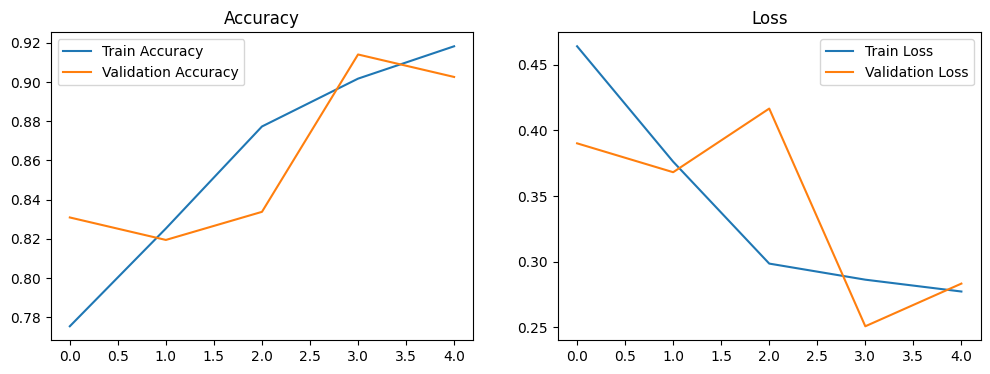

In [22]:
# 5. (Tùy chọn) Vẽ đồ thị accuracy và loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## 5. Combined CNN and LSTM Model Training
Systematically divided into three sets: training (80%), and test (20%). Training set instructs the combined of CNN and LSTM, enabling it to learn patterns and relationships within the data. 

In [23]:
# Define input variable and target variable
reviews = pd.DataFrame(reviews_data['text'])
labels = pd.DataFrame(reviews_data['sentiment'])

# Split the dataset into 3 parts, including training set (80%), validation set (10%), and test set (10%)
reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(reviews, labels, test_size=0.2, random_state=100)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(reviews_temp, labels_temp, test_size=0.5, random_state=100)

In [24]:
reviews

,text
0,Very easy to use to view statements and make o...
1,Merrick Bank has always been good to me for bu...
2,Times are tough for everyone and I have worked...
3,I can not asked for a better Credit Card Compa...
4,Updated on 02/10/2023: I was happy to sign for...
...,...
3494,"I own a property with my sister, and since she..."
3495,Really don't know where to start but I really ...
3496,I have now spent more time trying just to spea...
3497,"I started a refi in November 2021, it's now Ap..."


In [25]:
labels

,sentiment
0,1
1,1
2,1
3,1
4,1
...,...
3494,0
3495,0
3496,0
3497,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

reviews = pd.DataFrame(reviews_data['text'], columns=['text'])
labels = pd.DataFrame(reviews_data['sentiment'], columns=['sentiment'])

reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(
    reviews, labels, test_size=0.2, random_state=100
)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(
    reviews_temp, labels_temp, test_size=0.5, random_state=100
)

max_words = 10000 
max_len = 100     

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews_train['text'])

X_train = tokenizer.texts_to_sequences(reviews_train['text'])
X_val = tokenizer.texts_to_sequences(reviews_val['text'])
X_test = tokenizer.texts_to_sequences(reviews_test['text'])

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

y_train = to_categorical(labels_train)
y_val = to_categorical(labels_val)
y_test = to_categorical(labels_test)

embedding_dim = 100  
filters = 128        
kernel_size = 5      
lstm_units = 128     
modelCNN_LSTM = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),

    Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),

    LSTM(lstm_units, return_sequences=False),

    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  
])

modelCNN_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = modelCNN_LSTM.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = modelCNN_LSTM.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7408 - loss: 0.5111 - val_accuracy: 0.8453 - val_loss: 0.3628
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8886 - loss: 0.2680 - val_accuracy: 0.9083 - val_loss: 0.2300
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9704 - loss: 0.1187 - val_accuracy: 0.9112 - val_loss: 0.3155
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9909 - loss: 0.0374 - val_accuracy: 0.9140 - val_loss: 0.3795
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9968 - loss: 0.0185 - val_accuracy: 0.9169 - val_loss: 0.3871
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9946 - loss: 0.0226 - val_accuracy: 0.9054 - val_loss: 0.4782
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9958 - loss: 0.0181 - val_accuracy: 0.9140 - val_loss: 0.3098
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9924 - loss: 0.0256 - val_accuracy: 0.9169 - val_loss: 0.

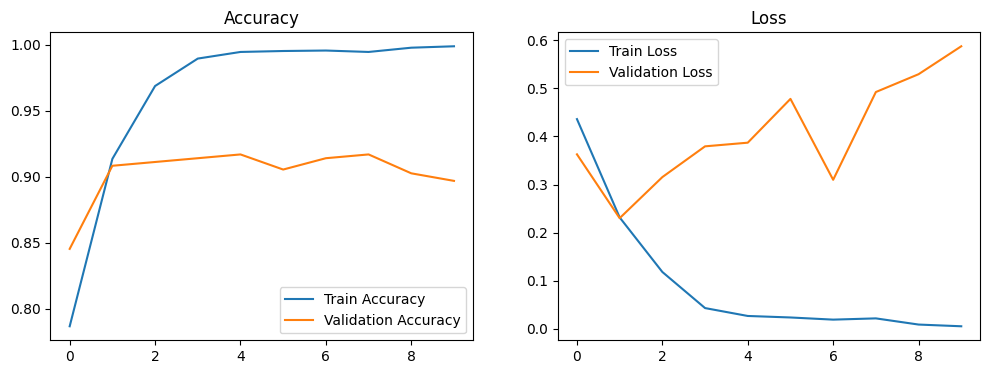

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## 6. Tokenization and Model Training
Systematically divided into three sets: training (80%), validation (10%), and test (10%). Training set instructs the BERT model, enabling it to learn patterns and relationships within the data. Validation set is crucial for fine-tuning the model, experimenting with hyperparameter configurations. Test set is for evaluating the model performance.

**Split the datset into 3 parts: Training set, Valiation set, Test set**

In [ ]:
reviews = pd.DataFrame(reviews_data['text'])
labels = pd.DataFrame(reviews_data['sentiment'])

reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(reviews, labels, test_size=0.2, random_state=100)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(reviews_temp, labels_temp, test_size=0.5, random_state=100)

In [29]:
reviews

,text
0,Very easy to use to view statements and make o...
1,Merrick Bank has always been good to me for bu...
2,Times are tough for everyone and I have worked...
3,I can not asked for a better Credit Card Compa...
4,Updated on 02/10/2023: I was happy to sign for...
...,...
3494,"I own a property with my sister, and since she..."
3495,Really don't know where to start but I really ...
3496,I have now spent more time trying just to spea...
3497,"I started a refi in November 2021, it's now Ap..."


In [30]:
labels

,sentiment
0,1
1,1
2,1
3,1
4,1
...,...
3494,0
3495,0
3496,0
3497,0


**Tokenize and encode the data using the BERT tokenizer**

In [ ]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the sentences for the training set, validation set, and test set
max_len = 256
train_encodings = tokenizer(reviews_train['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(reviews_val['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(reviews_test['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Convert sentiment labels to PyTorch tensors
train_labels = torch.tensor(labels_train['sentiment'].tolist())
val_labels = torch.tensor(labels_val['sentiment'].tolist())
test_labels = torch.tensor(labels_test['sentiment'].tolist())

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
train_encodings

{'input_ids': tensor([[ 101, 2699, 2000,  ...,    0,    0,    0],
        [ 101, 1045, 2052,  ...,    0,    0,    0],
        [ 101, 1996, 2924,  ...,    0,    0,    0],
        ...,
        [ 101, 2348, 1010,  ...,    0,    0,    0],
        [ 101, 2149, 2924,  ...,    0,    0,    0],
        [ 101, 1045, 2031,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

**Create DataLoader**

In [33]:
# Define datasets using TensorDataset, containing input_ids, attention_mask, and labels
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Define batch size
batch_size = 32

# Create DataLoader for training set , validation set, and test set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
# Load Pre-trained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Fine-Tuning BERT model using Validation Set**

In [35]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [42]:
# Move the model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer (AdamW) with a learning rate of 2e-5
optimizer = AdamW(model.parameters(), lr=2e-5)

# Lists to store values for plotting
train_loss_values = []
val_accuracy_values = []
training_times = []
memory_allocated_values = []

# Initialize a PrettyTable
table = PrettyTable()
table.field_names = ["Epoch", "Training Loss", "Validation Accuracy", "Training Time (s)", "Max GPU Memory Allocated (MB)"]

# Number of training epochs
num_epochs = 3

# Loop through each epoch
for epoch in range(num_epochs):

    # Record the start time
    start_time = time.time()

    # Set the model to training mode and initialize total loss for the epoch
    model.train()
    total_loss = 0.0

    # Loop through the training data in batches
    for batch in train_loader:

        # Move input data to the appropriate device
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Zero the gradients to prevent accumulation from previous batches
        optimizer.zero_grad()

        # Forward pass: calculate model predictions and compute the loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = F.cross_entropy(outputs.logits, labels)
        total_loss += loss.item()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Optimization step: update model parameters using the optimizer
        optimizer.step()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Record the end time
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time

    # Set the model to evaluation mode to evaluate the performance of each epoch
    model.eval()

    # Initialize total correct predictions and total samples for validation
    total_correct = 0
    total_samples = 0

    # Disable gradient computation during validation
    with torch.no_grad():

        # Loop through the validation data in batches
        for batch in val_loader:

            # Move input data to the appropriate device
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Forward pass: calculate model predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            # Update total correct predictions and total samples
            total_correct += torch.sum(predictions == labels).item()
            total_samples += labels.size(0)

    # Calculate validation accuracy
    accuracy = total_correct / total_samples

    # Record the end time
    end_time = time.time()

    # Check GPU memory (MB)
    max_memory_allocated = torch.cuda.max_memory_allocated() / 1024 ** 2

    # Print result of the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss}, Validation Accuracy: {accuracy}')
    print(f'Training Time for Epoch {epoch + 1}: {training_time:.2f} seconds')
    print(f'Max GPU Memory Allocated: {max_memory_allocated:.2f} MB')

    # Add values to the lists for plotting
    train_loss_values.append(average_loss)
    val_accuracy_values.append(accuracy)
    training_times.append(training_time)
    memory_allocated_values.append(max_memory_allocated)

    # Add the results to the PrettyTable
    table.add_row([epoch + 1, average_loss, accuracy, training_time, max_memory_allocated])

    # Reser GPU memory statistics
    torch.cuda.reset_max_memory_allocated()

# Plotting the graphs
epochs_range = range(1, num_epochs + 1)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.08399481551234865, Validation Accuracy: 0.9627507163323782
Training Time for Epoch 1: 285.41 seconds
Max GPU Memory Allocated: 17695.44 MB


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 2/3, Training Loss: 0.05291080900827761, Validation Accuracy: 0.9570200573065902
Training Time for Epoch 2: 379.45 seconds
Max GPU Memory Allocated: 17695.44 MB
Epoch 3/3, Training Loss: 0.032033404388295654, Validation Accuracy: 0.9541547277936963
Training Time for Epoch 3: 366.07 seconds
Max GPU Memory Allocated: 17695.44 MB


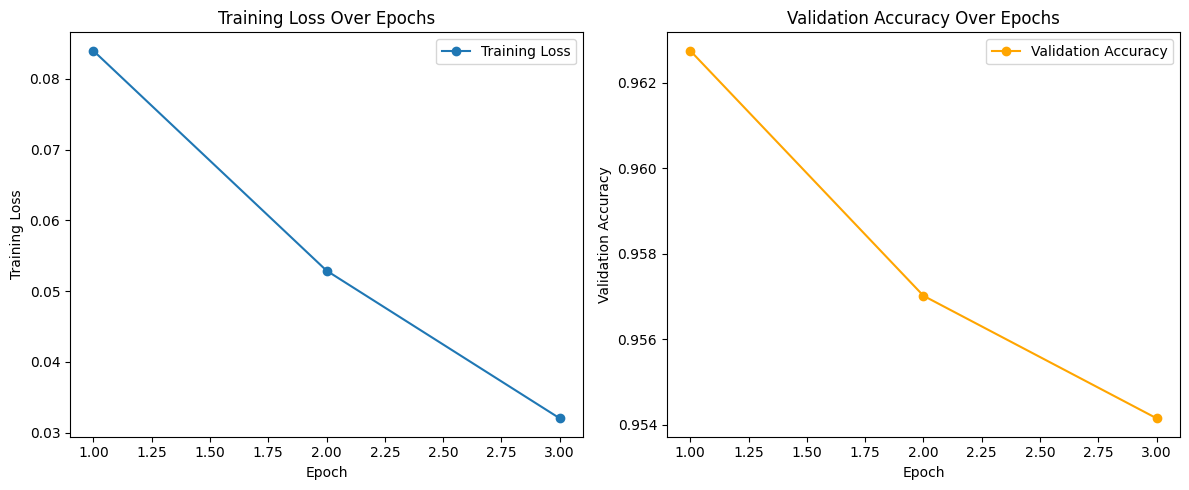

+-------+----------------------+---------------------+--------------------+-------------------------------+
| Epoch |    Training Loss     | Validation Accuracy | Training Time (s)  | Max GPU Memory Allocated (MB) |
+-------+----------------------+---------------------+--------------------+-------------------------------+
|   1   | 0.08399481551234865  |  0.9627507163323782 | 285.41459250450134 |       17695.44287109375       |
|   2   | 0.05291080900827761  |  0.9570200573065902 | 379.45015025138855 |       17695.44287109375       |
|   3   | 0.032033404388295654 |  0.9541547277936963 | 366.0687005519867  |       17695.44287109375       |
+-------+----------------------+---------------------+--------------------+-------------------------------+


In [43]:
# Set the size of the graph
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracy_values, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Print the table
print(table)

## 7. Classification and Evaluation
Evaluate the model performance to classify the reviews between positive and negative reviews on Test dataset.

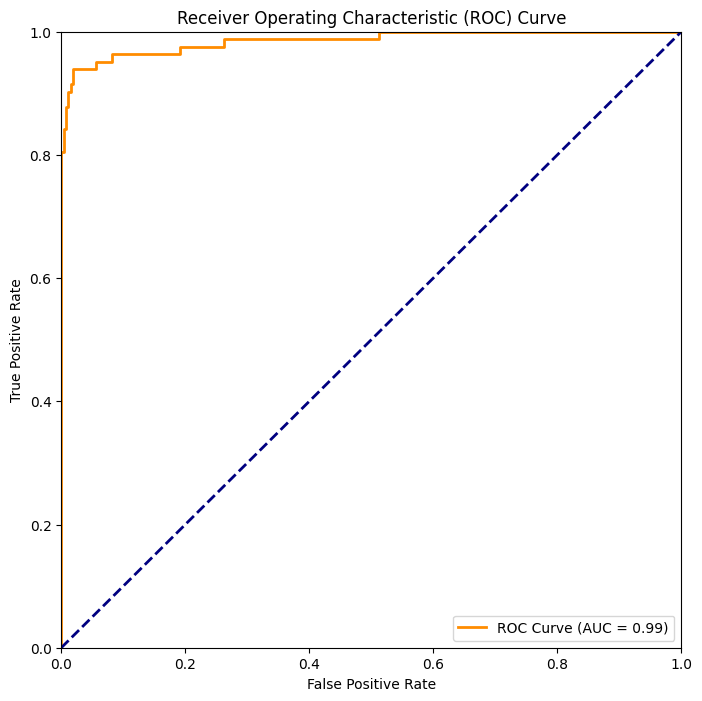

ROC-AUC Score: 0.9852
Accuracy: 0.9713


In [44]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []
predicted_labels = []

# Evaluate the Model on the Test Set
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)[:, 1]
        predictions = torch.argmax(logits, dim=1)

        # Collect true labels and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probabilities.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(true_labels, predicted_probs)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print ROC-AUC Score and Accuracy
print(f'ROC-AUC Score: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')

**Manual evaluation**

In [ ]:
# 10 unseen reviews for manual test
unseen_reviews = ["Impressed with the bank's online services, making transactions has never been easier.",
                  "Customer support was unhelpful and frustrating; it took forever to resolve a simple issue.",
                  "Received a great interest rate on my savings account, very satisfied with the banking experience.",
                  "The mobile app is user-friendly and convenient for managing accounts on the go.",
                  "Unexpected fees and hidden charges made my experience with this bank disappointing.",
                  "Quick and efficient loan approval process, would recommend for financial assistance.",
                  "The staff at the local branch were friendly and assisted me with professionalism.",
                  "I've been a customer for years, and the bank has consistently met my financial needs.",
                  "The credit card application process was straightforward, and I got approved quickly.",
                  "Poor security measures; my account was compromised, and the recovery process was frustrating."]

# Sentiment for 10 unseen reviews
sentiment_unseen_reviews = ['Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative']

# Clean the text
cleaned_unseen_reviews = []

# Tokenize and encode the unseen reviews
unseen_encodings = tokenizer(unseen_reviews, padding=True, truncation=True, return_tensors='pt')

# Make predictions
model.eval()
with torch.no_grad():
    inputs = {key: unseen_encodings[key].to(model.device) for key in unseen_encodings}
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

# Print the predicted sentiment for each review
i = 0
for review, prediction in zip(unseen_reviews, predictions.tolist()):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\nTrue Sentiment: {sentiment_unseen_reviews[i]}\n")
    i += 1

Review: Impressed with the bank's online services, making transactions has never been easier.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: Customer support was unhelpful and frustrating; it took forever to resolve a simple issue.
Predicted Sentiment: Negative
True Sentiment: Negative

Review: Received a great interest rate on my savings account, very satisfied with the banking experience.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: The mobile app is user-friendly and convenient for managing accounts on the go.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: Unexpected fees and hidden charges made my experience with this bank disappointing.
Predicted Sentiment: Negative
True Sentiment: Negative

Review: Quick and efficient loan approval process, would recommend for financial assistance.
Predicted Sentiment: Positive
True Sentiment: Positive

Review: The staff at the local branch were friendly and assisted me with professionalism.
Pr